

> ***NOTE: Worked on Google Colab.***



In [ ]:
import zipfile
import os

# Define the path to the ZIP file
zip_path = "/content/plate_recgonition.zip"

# Extract it
extract_path = "/content/plate_recgonition"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
# Check extracted folders
print("Folders inside dataset:", os.listdir(extract_path))

Folders inside dataset: ['CNN letter Dataset']


In [ ]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# **def load_images**
- **Libraries Used**
1. **os**

Standard Python library for working with files and directories.
Used to list folders and files inside the dataset directory.
Functions used:
os.listdir(folder): Lists files/folders inside folder.
os.path.isdir(path): Checks if path is a directory.
2. **cv2 (OpenCV)**

Open-source computer vision library used for image processing.
Functions used:
cv2.imread(path, cv2.IMREAD_GRAYSCALE): Reads an image in grayscale.
cv2.resize(image, (width, height)): Resizes the image to a fixed size.
3. **numpy**

Library for numerical computing with arrays.
Functions used:
np.array(list, dtype=np.float32): Converts a list to a NumPy array.
.astype(np.float32): Changes the data type of an array.
4. **torch (PyTorch)**

Deep Learning library used for handling tensors.
Functions used:
torch.from_numpy(numpy_array): Converts a NumPy array to a PyTorch tensor.

X_list, y_list = [], []

X_list: Stores flattened images (1D arrays).

y_list: Stores class labels (integers).

os.listdir(folder): Lists all files and folders inside folder.

os.path.isdir(path): Keeps only directories (ignores files).

sorted(...): Sorts class names alphabetically (e.g., 0,1,2,...,A,B,...Z).

class_names: List of class folder names.

enumerate(class_names):
Assigns a unique label (integer) to each class.

- os.listdir(class_folder):
  - Lists all image files in the class folder.
- os.path.join(class_folder, fname):
  - Creates the full file path to the image.

- Normalize & Flatten Image
  - img = img.astype(np.float32) / 255.0
    - Converts pixel values from 0-255 to 0-1 (normalization).
    - .astype(np.float32): Ensures precision in calculations.
  - X_list.append(img.flatten())
    - Flattens the image (16x16 → 1x256).
    - Adds the flattened image to X_list.

- Store Label
  - y_list.append(label)
    - Adds the class label to y_list.
- Convert Lists to NumPy Arrays
  - X_arr = np.array(X_list, dtype=np.float32)
  - y_arr = np.array(y_list, dtype=np.int64)
    - X_arr: Stores images as a NumPy array.
    - y_arr: Stores labels as a NumPy array.
- Convert to PyTorch Tensors
  - X_tensor = torch.from_numpy(X_arr)
  - y_tensor = torch.from_numpy(y_arr)
    - Converts X_arr and y_arr into PyTorch tensors.
    - torch.FloatTensor: Used for images.
    - torch.LongTensor: Used for labels.
- Return Results
  - return X_tensor, y_tensor, class_names
- Returns:
  - X_tensor: Tensor of all images ([num_samples, img_size*img_size]).
  - y_tensor: Tensor of labels ([num_samples]).
  - class_names: List of class names (strings).

In [ ]:
###############################################################################
# 1. DATA LOADING FUNCTION
###############################################################################
def load_images(folder, img_size):
    """
    Loads images from subfolders, each folder is one class.
    Returns:
      X: torch.FloatTensor [num_samples, img_size*img_size]
      y: torch.LongTensor   [num_samples]
      class_names: list of subfolder names (strings), sorted
    """
    X_list, y_list = [], []
    class_names = sorted([d for d in os.listdir(folder)
                          if os.path.isdir(os.path.join(folder, d))])

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        for fname in os.listdir(class_folder):
            fpath = os.path.join(class_folder, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, (img_size, img_size))
            img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
            X_list.append(img.flatten())
            y_list.append(label)

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.int64)

    X_tensor = torch.from_numpy(X_arr)
    y_tensor = torch.from_numpy(y_arr)
    return X_tensor, y_tensor, class_names

# **class AdalineSlides:**
**Libraries Used**
1. **torch (PyTorch)**
  - Why is it used?
    - We use torch only as a data structure (tensor operations).
    - No automatic differentiation, loss functions, or optimizers are used.
  - Functions Used:
    - **torch.randn(num_features) * 0.01:** Initializes weights with small random values.
    - **torch.zeros(1):** Initializes the bias to 0.
    - **torch.dot(self.weights, x):** Computes the dot product (weighted sum).

- Defines the learning rule as per slides:
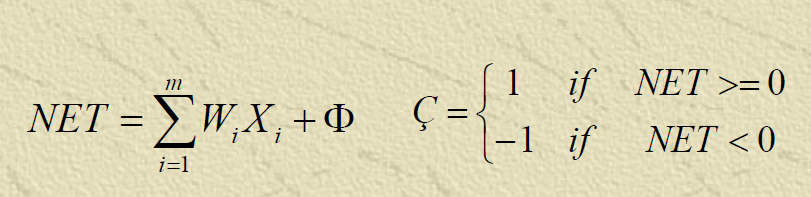

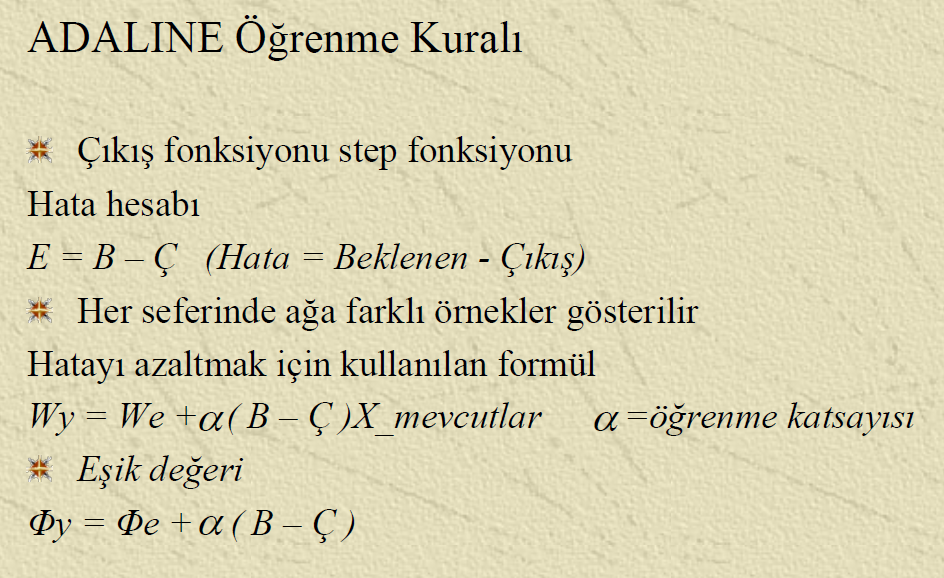

- B is the true label.
- 𝐶 is the predicted class (step function output).
- 𝛼 is the learning rate.



```
def __init__(self, num_features, learning_rate=0.01):
    self.lr = learning_rate
    # Small random init to avoid large net inputs initially
    self.weights = torch.randn(num_features) * 0.01
    self.bias = torch.zeros(1)
```

  - num_features → The number of input features (e.g., 16×16 = 256 pixels for images).
  - learning_rate (self.lr) → Defines how much weights are updated in each step.

- **Weight Initialization**
```
self.weights = torch.randn(num_features) * 0.01
```
  - Generates small random weights (torch.randn) to avoid large initial outputs.
  - Multiplying by 0.01 ensures small values, preventing the model from diverging.

- **Bias Initialization**
```
self.bias = torch.zeros(1)
```
  - Initializes bias (threshold Φ) to 0.

- **Computing NET Input**
```
def net_input(self, x):
    """
    x: shape [num_features]
    returns: scalar = W·x + bias
    """
    return torch.dot(self.weights, x) + self.bias
```
  - Computes the weighted sum (NET):
  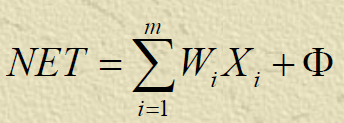

- Uses torch.dot(self.weights, x), which is equivalent to matrix multiplication:

```
net = W_1*X_1 + W_2*X_2 + ... + W_n*X_n + bias
```
* Returns a single scalar (the NET value for one sample).

- Weight and Bias Update in Code


```
net = self.net_input(x)  
c = self.activation(net)  
error = b - c  

# Update weights
self.weights += self.lr * error * x
self.bias += self.lr * error
```
- Step-by-step breakdown:
  - net = self.net_input(x): Compute NET input.
  - c = self.activation(net): Apply step function.
  - error = b - c: Compute error.
  - self.weights += self.lr * error * x: Adjust weights.
  - self.bias += self.lr * error: Adjust bias.


In [ ]:
###############################################################################
# 2. ADALINE MODEL (DIRECT UPDATE FROM SLIDES)
###############################################################################
class AdalineSlides:
    """
    Implements the Adaline model exactly as in the slides:
      - NET = W·X + bias
      - Output C = +1 if NET>=0, else -1
      - Update rule: W_i += alpha*(B - C)*X_i, bias += alpha*(B - C)
    """
    def __init__(self, num_features, learning_rate=0.01):
        self.lr = learning_rate
        # Small random init to avoid large net inputs initially
        self.weights = torch.randn(num_features) * 0.01
        self.bias = torch.zeros(1)

    def net_input(self, x):
        """
        x: shape [num_features]
        returns: scalar = W·x + bias
        """
        return torch.dot(self.weights, x) + self.bias

    def activation(self, net):
        """
        Step function: +1 if net >= 0, else -1
        """
        return 1.0 if net >= 0 else -1.0

    def update_weights(self, x, b):
        """
        b: the true label (either +1 or -1)
        1) Compute net, step output
        2) Error = (b - c)
        3) W_i += lr * (b - c) * x_i
           bias += lr * (b - c)
        """
        net = self.net_input(x)
        c = self.activation(net)
        error = b - c
        # Update
        self.weights += self.lr * error * x
        self.bias += self.lr * error

    def predict_sample(self, x):
        """
        Predict for a single sample.
        Returns +1 or -1.
        """
        net = self.net_input(x)
        return self.activation(net)

# **def train_adaline_slides**
-  **Libraries Used**
1. **torch (PyTorch)**
  - Used only for tensor operations (not for ML training).
  - Functions Used:
    - **torch.manual_seed(seed):** Ensures consistent shuffling for reproducibility.
    - **torch.randperm(size):** Creates a random permutation of indices to shuffle data

- **Parameters**
  - **model:** An instance of AdalineSlides (the Adaline model).
  - **X:** Training data (features) → Shape [num_samples, num_features].
  - **y:** Training labels (must be +1 or -1).
  - **epochs:** Number of training epochs.
  - **seed:** Random seed for shuffling the data.

- **Return Value**
  - **accuracy_list:** A list of accuracy values for each epoch.

In [ ]:
###############################################################################
# 3. TRAINING FUNCTION (SAMPLE-BY-SAMPLE)
###############################################################################
def train_adaline_slides(model, X, y, epochs, seed=123):
    """
    model:      AdalineSlides instance
    X, y:       training data
    y in {+1, -1}
    epochs:     number of training epochs
    seed:       random seed for shuffling
    Returns:
      accuracy_list: list of accuracy per epoch
    """
    torch.manual_seed(seed) # If no seed is set, results change every time the code runs.
    accuracy_list = []  # Stores training accuracy after each epoch.

    for epoch in range(epochs):
        # Shuffle each epoch
        # Prevents order bias (so the model sees different data order each time).
        idx = torch.randperm(y.size(0)) # Generates random indices (torch.randperm(y.size(0))).
        X = X[idx] # Reorders both X and y based on the shuffled indices.
        y = y[idx]

        # Train sample-by-sample
        for i in range(X.size(0)):
            x_i = X[i]  # x_i = X[i]: Extracts one sample.
            b_i = y[i].item()  # b_i = y[i].item(): Extracts the true label (+1 or -1).
            model.update_weights(x_i, b_i)  # # Update weights

        # Compute accuracy on the training set after this epoch
        correct = 0
        for i in range(X.size(0)):
            pred = model.predict_sample(X[i])
            if pred == y[i].item(): # Compares prediction (pred) with true label (y[i])
                correct += 1  # Increments correct counter if prediction is correct.

        # Compute & Store Accuracy
        acc = 100.0 * correct / X.size(0)
        accuracy_list.append(acc)
        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc:.2f}%")

    return accuracy_list

# **ONE-VS-ALL TRAINING AND PREDICTION**

- **Libraries Used**
1. **torch (PyTorch)**
  - Used only for tensor operations, not for learning.
  - Functions Used:
    - **torch.where(condition, x, y):** Converts labels to +1 or -1 for binary classification.
    - **torch.zeros(num_models, num_samples):** Creates a tensor for storing NET values.
    - **torch.tensor(list):** Converts a list into a tensor.
    - **torch.argmax(tensor, dim=0):** Finds the class with the highest NET input.

## **one_vs_all_train (Training Multiple Adaline Models)**
- **Purpose**
  - Trains multiple Adaline models, one for each class (One-Vs-All).
  - Converts labels:
    - For class i, set:
      - 𝑦={+1,if label=𝑖
      - y={−1,otherwise

  - Each Adaline learns to classify:
    - Class i = +1,
    - All other classes = -1.
- **Parameters**
  - **X_train:** Training data ([num_samples, num_features]).
  - **y_train:** Labels ([num_samples], original classes).
  - **class_names:** List of class names (e.g., ["A", "B", "0", "1", "2", ...]).
  - **epochs:** Number of training epochs.
  - **lr:** Learning rate.
- **Return Values**
  - **models:** List of trained Adaline models (one for each class).
  - **accuracy_dict:** Dictionary of training accuracies per epoch per class

## **one_vs_all_predict (Making Predictions)**
- **Purpose**
  - Uses multiple Adaline models to classify test samples.
  - Each model outputs a NET score, and we pick the highest.
  - No step function is applied (we only compare NET values).
- **Parameters**
  - **models:** List of trained Adaline models.
  - **X:** Test data ([num_samples, num_features]).
- **Return Value**
  - **preds:** Predicted class labels ([num_samples]).

In [ ]:
###############################################################################
# 4. ONE-VS-ALL TRAINING AND PREDICTION (SLIDES)
###############################################################################
def one_vs_all_train(X_train, y_train, class_names, epochs, lr):
    """
    For each class i, map y to +1 if y==i, else -1,
    then train a separate AdalineSlides model.
    """
    models = [] # Stores trained models (one per class).
    accuracy_dict = {}  # Stores training accuracy curves.
    num_features = X_train.size(1)  # Gets feature count (img_size * img_size).

    for i, cname in enumerate(class_names):
        print(f"\nTraining Adaline for class '{cname}' (label={i})")
        # Convert y to +1 if label==i, else -1
        # Converts multi-class labels to binary (+1, -1)
        # example:
        # y_train:  [0, 1, 1, 2, 0, 1, 2]
        # y_bin  :  [-1, 1, 1, -1, -1, 1, -1]
        y_bin = torch.where(y_train == i, torch.tensor(1), torch.tensor(-1))

        model = AdalineSlides(num_features, learning_rate=lr) # Creates a new Adaline model for the class.
        accuracies = train_adaline_slides(model, X_train, y_bin, epochs=epochs) # Trains the model using train_adaline_slides().
        models.append(model)  # Adds the trained model to models[].
        accuracy_dict[cname] = accuracies # Saves accuracy results in accuracy_dict{}.

    return models, accuracy_dict

def one_vs_all_predict(models, X):
    """
    For each sample, pick the class whose NET input is the highest.
    (We do NOT apply the step function here; we just pick the max net.)
    """
    num_models = len(models)  # Number of Adaline models (equal to number of classes).
    num_samples = X.size(0) # Number of test samples.

    # Each model's net input for all samples
    # Creates a tensor ([num_classes, num_samples]).
    # Stores each model's NET scores for all test samples
    all_net = torch.zeros(num_models, num_samples)

    #  Compute NET Scores
    for i, model in enumerate(models):
        # net_input for all samples
        net_vals = [] #  Stores NET scores.
        for j in range(num_samples):
            net_vals.append(model.net_input(X[j]))  # Computes NET score.
        all_net[i] = torch.tensor(net_vals) # Stores all NET scores in

    # Argmax along the class dimension => best class
    preds = torch.argmax(all_net, dim=0)  # Finds index of the highest NET score for each sample
    return preds

In [ ]:
# ======= DYNAMIC USER INPUT =========
dataset_path = "/content/plate_recgonition/CNN letter Dataset/"
try:
    img_size = int(input("Enter image size (default=64): ") or 64)
    epochs = int(input("Enter number of epochs (default=5): ") or 5)
    lr = float(input("Enter learning rate (default=0.0001): ") or 0.0001)
    test_size = float(input("Enter test size (default=0.2): ") or 0.2)
except ValueError:
    print("Invalid input. Using defaults.")
    img_size = 64
    epochs = 5
    lr = 0.0001
    test_size = 0.2

Enter image size (default=64): 64
Enter number of epochs (default=5): 10
Enter learning rate (default=0.0001): 0.0001
Enter test size (default=0.2): 0.2


In [ ]:
# 1) Load the dataset
X, y, class_names = load_images(dataset_path, img_size)
print(f"\nLoaded data with shape: {X.shape} (samples x features)")
print("Classes:", class_names)


Loaded data with shape: torch.Size([35500, 4096]) (samples x features)
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
# Basic stats about pixel intensities
print(f"Min pixel value: {X.min().item():.4f}")
print(f"Max pixel value: {X.max().item():.4f}")
print(f"Mean pixel value: {X.mean().item():.4f}")
print(f"Std pixel value: {X.std().item():.4f}")

Min pixel value: 0.0000
Max pixel value: 1.0000
Mean pixel value: 0.4913
Std pixel value: 0.2208


In [ ]:
# Basic stats about pixel intensities
print(f"Min pixel value: {X.min().item():.4f}")
print(f"Max pixel value: {X.max().item():.4f}")
print(f"Mean pixel value: {X.mean().item():.4f}")
print(f"Std pixel value: {X.std().item():.4f}")

Min pixel value: 0.0000
Max pixel value: 1.0000
Mean pixel value: 0.4913
Std pixel value: 0.2208


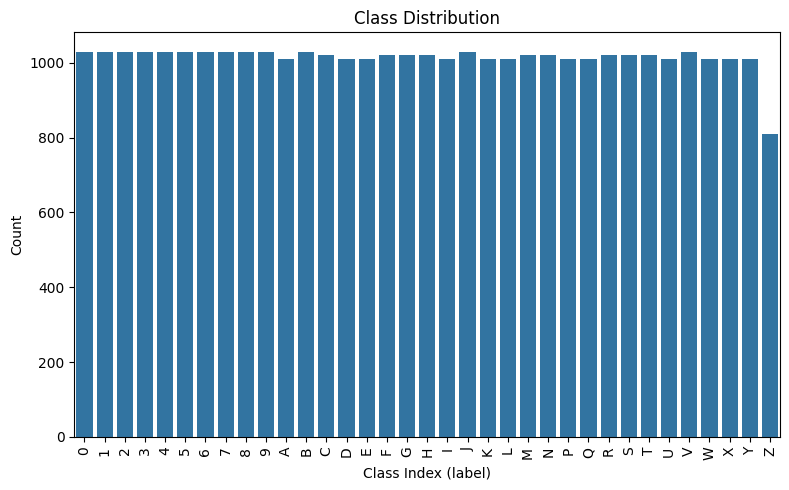

In [ ]:
# ----- EDA 1: Distribution of Classes -----
plt.figure(figsize=(8,5))
sns.countplot(x=y.numpy())
plt.title("Class Distribution")
plt.xlabel("Class Index (label)")
plt.ylabel("Count")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.tight_layout()
plt.show()

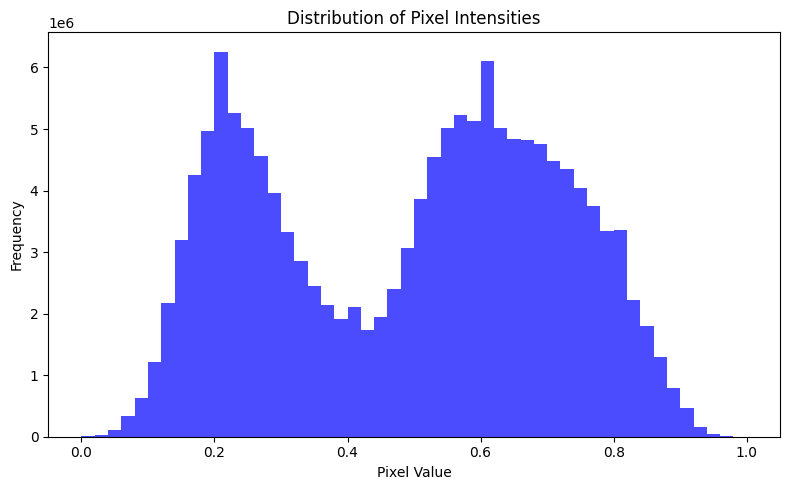

In [ ]:
# ----- EDA 2: Distribution of Pixel Intensities -----
plt.figure(figsize=(8,5))
# Flatten across all samples & pixels
all_pixels = X.view(-1).numpy()
plt.hist(all_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

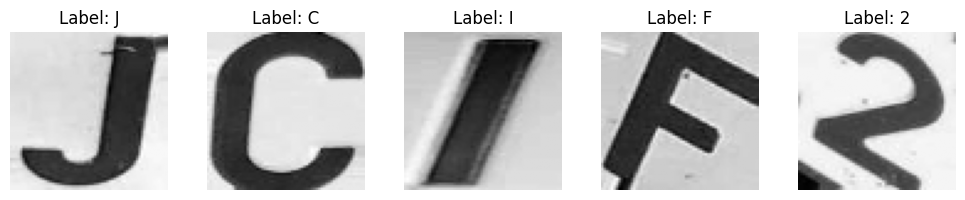

In [ ]:
# ----- EDA 3: Show sample images -----
# We show up to 5 random samples
plt.figure(figsize=(10,2))
rand_indices = torch.randperm(X.size(0))[:5]
for i, idx in enumerate(rand_indices):
  img_array = X[idx].view(img_size, img_size).numpy()
  label_idx = y[idx].item()

  plt.subplot(1, 5, i+1)
  plt.imshow(img_array, cmap='gray')
  plt.title(f"Label: {class_names[label_idx]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

- **Libraries Used**
1. **sklearn.model_selection (Scikit-Learn)**
  - Scikit-learn is a machine learning library that provides tools for data preprocessing and model evaluation.
  - The function train_test_split is used to randomly split the dataset into training and testing subsets.

- stratify=y (Balanced Class Distribution)
  - Ensures class proportions remain the same in both train and test sets.
  - Why is this important?
    - Without stratification, random splitting may result in some classes being overrepresented or missing in the test set.

In [ ]:
# 2) Split into train/test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=123
)

- **Libraries Used**
1. torch (PyTorch)
  - Used for tensor operations (not ML training).
  - Functions Used:
    - .mean(dim=0): Computes column-wise mean.
    - .std(dim=0): Computes column-wise standard deviation.
    - +1e-8: Prevents division by zero.

In [ ]:
# 3) Standardize

# Computes the mean of each feature across all training samples.
# dim=0 → Column-wise mean (one mean per feature).
mu = X_train.mean(dim=0)

# Adds 1e-8 to prevent division by zero (when variance is 0).
sigma = X_train.std(dim=0) + 1e-8 # Computes the standard deviation of each feature across all training samples.

# Standardize Training Data
# Subtracts the mean (mu) from each sample
# Divides by standard deviation (sigma).
# Ensures zero mean and unit variance.
X_train_std = (X_train - mu) / sigma

# Standardize Test Data
X_test_std  = (X_test  - mu) / sigma

In [ ]:
# 4) Train one-vs-all Adaline (slides version)
models, accuracy_dict = one_vs_all_train(X_train_std, y_train, class_names,
                                         epochs=epochs, lr=lr)


Training Adaline for class '0' (label=0)
Epoch 1/10, Accuracy: 89.54%
Epoch 2/10, Accuracy: 94.33%
Epoch 3/10, Accuracy: 97.09%
Epoch 4/10, Accuracy: 96.92%
Epoch 5/10, Accuracy: 98.29%
Epoch 6/10, Accuracy: 95.67%
Epoch 7/10, Accuracy: 98.50%
Epoch 8/10, Accuracy: 97.27%
Epoch 9/10, Accuracy: 98.02%
Epoch 10/10, Accuracy: 97.84%

Training Adaline for class '1' (label=1)
Epoch 1/10, Accuracy: 95.86%
Epoch 2/10, Accuracy: 98.32%
Epoch 3/10, Accuracy: 98.22%
Epoch 4/10, Accuracy: 98.76%
Epoch 5/10, Accuracy: 98.48%
Epoch 6/10, Accuracy: 98.85%
Epoch 7/10, Accuracy: 98.94%
Epoch 8/10, Accuracy: 97.86%
Epoch 9/10, Accuracy: 99.05%
Epoch 10/10, Accuracy: 98.91%

Training Adaline for class '2' (label=2)
Epoch 1/10, Accuracy: 96.64%
Epoch 2/10, Accuracy: 97.13%
Epoch 3/10, Accuracy: 96.16%
Epoch 4/10, Accuracy: 97.85%
Epoch 5/10, Accuracy: 99.06%
Epoch 6/10, Accuracy: 99.24%
Epoch 7/10, Accuracy: 98.82%
Epoch 8/10, Accuracy: 98.85%
Epoch 9/10, Accuracy: 99.39%
Epoch 10/10, Accuracy: 99.22%



<ipython-input-16-a0c3bbe2e320>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


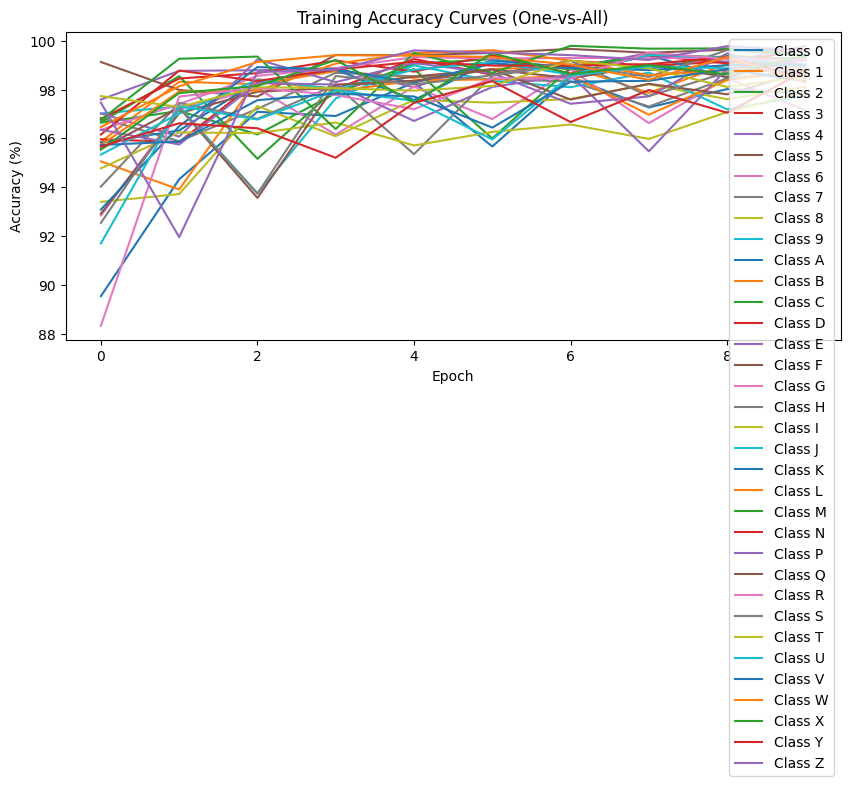

In [ ]:
# Plot training accuracy curves (optional)
plt.figure(figsize=(10, 4))
for cname in class_names:
    plt.plot(accuracy_dict[cname], label=f"Class {cname}")
plt.title("Training Accuracy Curves (One-vs-All)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 5) Evaluate on test set
y_pred = one_vs_all_predict(models, X_test_std)
accuracy = (y_pred == y_test).float().mean().item() * 100
print("\n===========================")
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 85.24%


In [ ]:
# Show first 10 predictions
print("Sample predictions:", [class_names[idx] for idx in y_pred[:10].tolist()])
print("Actual labels     :", [class_names[idx] for idx in y_test[:10].tolist()])

Sample predictions: ['S', 'Q', '0', 'J', '8', '3', '3', '6', 'E', 'W']
Actual labels     : ['S', 'Q', '0', 'Y', '8', '3', 'I', '6', 'E', 'W']


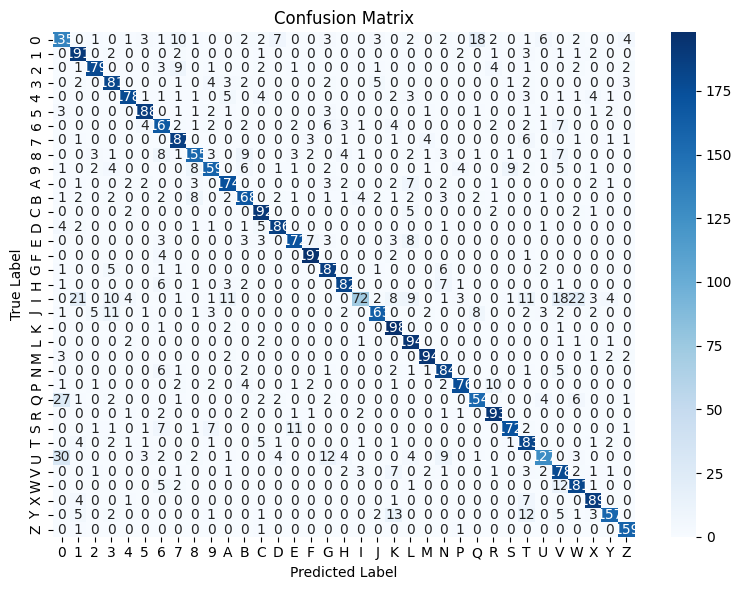

In [ ]:
# ----- EDA 5: Confusion Matrix -----
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# ----- EDA 6: Classification Report -----
print("\nClassification Report:")
print(classification_report(y_test.numpy(), y_pred.numpy(), target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       206
           1       0.81      0.93      0.86       206
           2       0.93      0.87      0.90       206
           3       0.81      0.88      0.84       206
           4       0.93      0.86      0.89       206
           5       0.92      0.91      0.92       206
           6       0.76      0.81      0.79       206
           7       0.84      0.91      0.87       206
           8       0.84      0.75      0.79       206
           9       0.85      0.77      0.81       206
           A       0.85      0.86      0.86       202
           B       0.83      0.82      0.82       206
           C       0.87      0.94      0.91       204
           D       0.92      0.92      0.92       202
           E       0.89      0.85      0.87       202
           F       0.93      0.97      0.95       204
           G       0.83      0.92      0.87       204
   